# Experiment 1 - Two Class Supervised & Unsupervised

## Details
Observe the effect of selective PN to iKC connectivity on the network's representational power.

### Model Info
**Random Sparse**: Neurons are connected randomly with probabilty $p = 0.05$ across the network. Network parameters:
\begin{align}
& g_{PN,iKC} \in \mathcal{N}(0.5, 0.05)\\
& g_{iKC,eKC} \in \mathcal{N}(1.25, 0.5)\\
& \tau_{PN,iKC} = \tau_{iKC,eKC} = 5\\
& p_{PN,iKC} = p_{iKC,eKC} = 0.05\\
\end{align}

All neurons are current-based LIFs with exponential post-synaptic decay. The following parameters are of note:
\begin{align}
&\tau_m = 10\\
&v_{thresh} = -50
\end{align}

The iKC and eKC populations form sWTA circuits by lateral inhibition:

Neuron population sizes are as follows:

\begin{align}
& N_{PN} = \frac{d_{input}}{4}\\
& N_{iKC} = 10 \times N_{PN}\\
& N_{eKC} = 500
\end{align}

where $d_{input}$ is the dimensionality of (flattened) image tensors.

Each input class contains 20 samples, each shown twice to the model, for a total sample size of $N_{sample} = 20 \times N_{class}$. In this experiment $N_{class} = 2$.

Prior to spike coding, images are downscaled by a factor of 4. Images are encoded into spike times as instantaneous snapshots plus a small amount of jitter $\epsilon$. $N_{sample}$ images are randomly drawn and spike encoded from the set of inputs, keeping the number of samples from each class balanced. During training, samples drawn are shown to the model within 50ms windows.

eKC neuron activity is measured as the spiking rate within a given interval.

To analyse eKC population activity, we calculate:
- Population distance tables (cosine and manhattan distance)
- Changes in mean pre-synaptic eKC weights over time
- Initial and final distribution of pre-synaptic eKC weights

## TODO
- [ ] Each run there seems to a sample that causes a large number of iKC (and thus eKC) neurons to fire. Find what image causes such a strong response
- [ ] Add functionality for supervision
- [ ] Add analysis for class distances

In [1]:
# Add my library
import sys
import os

sys.path.append(os.getcwd() + "/lib")

In [2]:
import numpy as np
import scipy
import h5py as h5
import matplotlib.pyplot as plt
import seaborn as sns

from two_class import get_inputs, run # Experiment script

from lib.util import retrieve_results
from lib.analysis import calculate_activity
from pyNN.utility.plotting import Figure, Panel

sns.set_style("whitegrid")

Inputs: (2, 40, 729)
Image Dimensions: 27 x 27
Image Vector: 729
Sparsity Ratio per-class: [0.92160494 0.93374486]


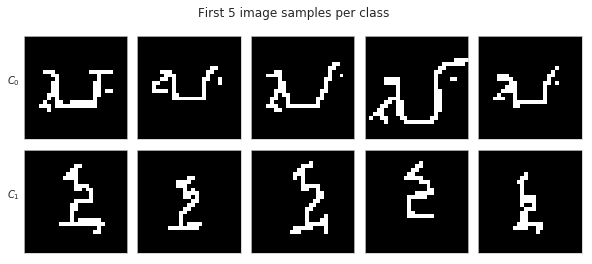

In [3]:
# Fetch inputs and preview examples
N_CLASS = 2
DOWNSCALE = 4

inputs = get_inputs(N_CLASS, DOWNSCALE)
inputs = np.tile(inputs, (2,1)) # Double sample set for 2 rounds of showing
print("Inputs:", inputs.shape)

samples = inputs[:,:5]
w = h = int(np.sqrt(samples.shape[-1]))

print(f"Image Dimensions: {w} x {h}")
print(f"Image Vector: {samples.shape[-1]}")
print(f"Sparsity Ratio per-class: {1-inputs.mean(axis=-1).mean(axis=-1)}")

fig, rows = plt.subplots(N_CLASS, 5, figsize=(10,4))
for i,axes in enumerate(rows):
    for j,(ax,img) in enumerate(zip(axes,samples[i])):
        if j == 0:
            ax.set_ylabel(fr"$C_{i}$".format(i), rotation=0, labelpad=10.0)
        ax.imshow(img.reshape(w,h), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

fig.suptitle("First 5 image samples per class")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [4]:
# Additional parameters
VERSION = 0
WEIGHT_LOG_FREQ = 20
SPIKE_JITTER = 2

In [5]:
run(
    inputs,
    spike_jitter=SPIKE_JITTER,
    weight_log_freq=WEIGHT_LOG_FREQ,
    run_id=VERSION
) 

Setting up
 -- steps: 2100
 -- n_PN: 729
 -- n_iKC: 7290
 -- n_eKC: 500
Initializing weight logger...
Running simulation..

[ ########################################################################### ] 100%        

Done
Saving results...
Saving simulation params...


{'steps': 2100,
 't_snapshot': 50,
 'intervals': array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
         600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100,
        1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650,
        1700, 1750, 1800, 1850, 1900, 1950])}

In [6]:
# Fetch data
data = retrieve_results("two_class", version=VERSION)
sim_params = np.load(f"results/two_class_{VERSION}/params.npz")
weights = np.load(f"results/two_class_{VERSION}/weights.npy")

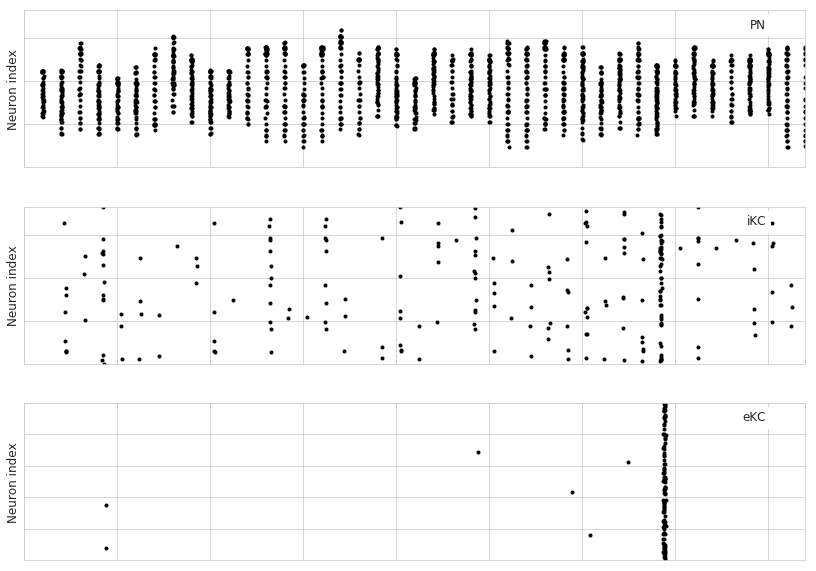

In [7]:
# Plot spikes

Figure(
    Panel(data['PN'].segments[0].spiketrains, data_labels=["PN"]),
    Panel(data['iKC'].segments[0].spiketrains, data_labels=["iKC"]),
    Panel(data['eKC'].segments[0].spiketrains, data_labels=["eKC"]),
    settings={ "font.size": 12 }
)

plt.gcf().set_size_inches(14,10)
plt.show()

## eKC activity

In [8]:
eKC_spiketrains = data['eKC'].segments[0].spiketrains
eKC_activity = calculate_activity(eKC_spiketrains, sim_params['intervals'], sim_params['t_snapshot'])

iKC_spiketrains = data['iKC'].segments[0].spiketrains
iKC_activity = calculate_activity(iKC_spiketrains, sim_params['intervals'], sim_params['t_snapshot'])

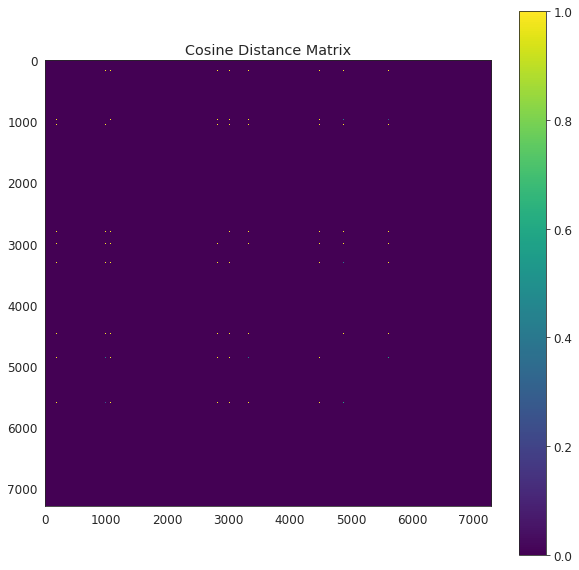

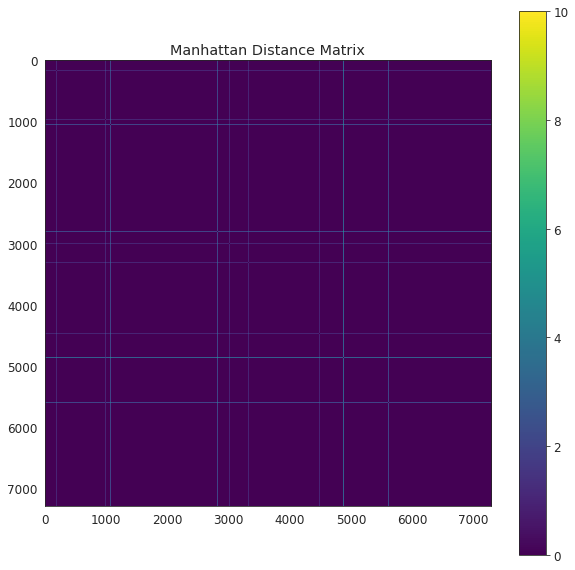

In [10]:
def distance_matrix(activity, metric):
    return np.nan_to_num(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(activity, metric=metric)))

sns.set_style("white")

plt.gcf().set_size_inches(10,10)

plt.imshow(distance_matrix(eKC_activity, 'cosine'), cmap='viridis')
plt.title("Cosine Distance Matrix")
plt.colorbar()
plt.show()

plt.gcf().set_size_inches(10,10)

plt.imshow(distance_matrix(eKC_activity, 'cityblock'), cmap='viridis')
plt.title("Manhattan Distance Matrix")
plt.colorbar()
plt.show()

## Weights Analysis

In [10]:
# Changes in weight
weights.shape

(105, 181606)

In [11]:
mean_trajectory = weights.mean(axis=-1)

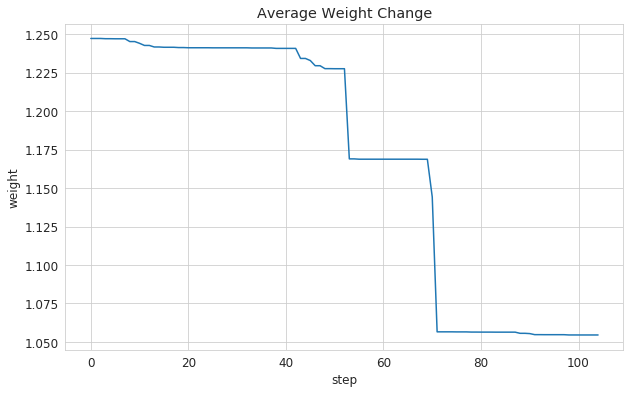

In [12]:
sns.set_style("whitegrid")
plt.plot(mean_trajectory)
plt.gcf().set_size_inches(10,6)
plt.title("Average Weight Change")
plt.xlabel("step")
plt.ylabel("weight")
plt.show()

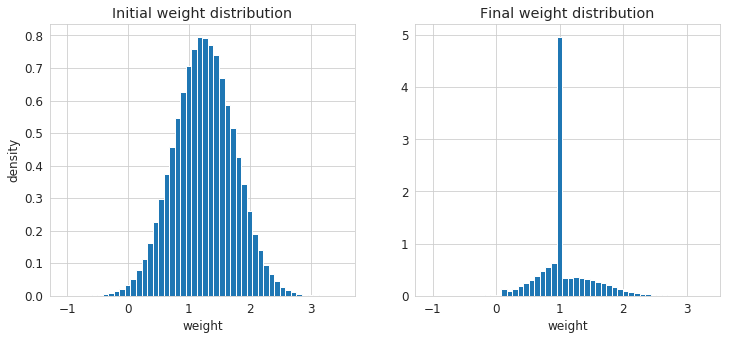

In [13]:
# Changes in distribution
ws = weights[1], weights[-1]
fig, axes = plt.subplots(1,2,figsize=(12,5))

for ax,w in zip(axes,ws):
    ax.set_xlabel("weight")
    ax.set_ylabel("density")
    ax.hist(w[~np.isnan(w)], bins=50, density=True)

axes[0].set_title("Initial weight distribution")    
axes[1].set_title("Final weight distribution")
axes[1].set_ylabel("")

plt.show()